# **Libraries**

In [1]:
import numpy as np 
import pandas as pd
import os
import cv2
import datetime
import matplotlib.pyplot as plt
from PIL import Image
import re
import gc
import keras
import glob
import random
import seaborn as sns
import tensorflow as tf
from mlxtend.plotting import plot_confusion_matrix

from keras.models import Sequential, Model, load_model
from keras.callbacks import TensorBoard, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD
from keras import backend as K
from tensorflow.python.framework import ops
from time import time
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,roc_auc_score
from keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Input, Activation, BatchNormalization
from tensorflow.nn import relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **One time execution**

In [ ]:
#pip install split-folders

In [ ]:
#import splitfolders

In [ ]:
'''
def split():
    data_dir = os.path.join('/content/drive/MyDrive/binary_data/data')
    print("No of images in each class of data directory")
    for dir, subdir, files in os.walk(data_dir):
        print(dir,':', str(len(files)))
        
    splitfolders.ratio("/content/drive/MyDrive/binary_data/data", 
                       output = "/content/drive/MyDrive/binary_data_folders",
                       seed = 6, 
                       ratio = (0.8, 0.2), 
                       group_prefix = None, 
                       move = False)

if os.path.exists("/content/drive/MyDrive/binary_data_folders"):
    print("Files already present in splitted ratio 0.8, 0.2")
else:
    split()
    print("Files are splitted in the ratio 0.8, 0.2")
'''

'\ndef split():\n    data_dir = os.path.join(\'/content/drive/MyDrive/binary_data/data\')\n    print("No of images in each class of data directory")\n    for dir, subdir, files in os.walk(data_dir):\n        print(dir,\':\', str(len(files)))\n        \n    splitfolders.ratio("/content/drive/MyDrive/binary_data/data", \n                       output = "/content/drive/MyDrive/binary_data_folders",\n                       seed = 6, \n                       ratio = (0.8, 0.2), \n                       group_prefix = None, \n                       move = False)\n\nif os.path.exists("/content/drive/MyDrive/binary_data_folders"):\n    print("Files already present in splitted ratio 0.8, 0.2")\nelse:\n    split()\n    print("Files are splitted in the ratio 0.8, 0.2")\n'

In [ ]:
'''
classes_dict = {0: 'no', 1: 'yes'}
def grey():
    for i in classes_dict.values():
        directory = "binary_data\\" + i
        for filename in os.listdir(directory):
            f = os.path.join(directory, filename)
            img = Image.open(f).convert("L")
            img = img.save(f)
grey()
'''

'\nclasses_dict = {0: \'no\', 1: \'yes\'}\ndef grey():\n    for i in classes_dict.values():\n        directory = "binary_data\\" + i\n        for filename in os.listdir(directory):\n            f = os.path.join(directory, filename)\n            img = Image.open(f).convert("L")\n            img = img.save(f)\ngrey()\n'

# **Utility function**

In [3]:
train = '/content/drive/MyDrive/binary_data_folders/train'
val = '/content/drive/MyDrive/binary_data_folders/val'

In [4]:
def show_few_images(number_of_examples = 2, predict_using_model = None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train)), figsize=(8, 4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train)):
        image_ids = os.listdir(os.path.join(train,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            display = plt.imread(os.path.join(train,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title + '\nPredict :' + predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

In [5]:
#function to show the number of files in each folder
def bar_plot(dir):
    x=len(os.listdir(dir+'/no'))
    y=len(os.listdir(dir+'/yes'))
    category = ['NO', 'YES']
    count = [x, y]
    plot = plt.bar(category,count) 
    plot[0].set_color('orange')
    plt.title('Plot of number of values for each category')
    plt.show()

In [6]:
def plot_performance_metrics(model):
    tr_loss = model.history['loss']
    val_loss = model.history['val_loss']

    tr_accuracy = model.history['acc']
    val_accuracy = model.history['val_acc']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plt.subplots_adjust(wspace=0.40)
    
    # Loss Plot
    ax1.plot(tr_loss)
    ax1.plot(val_loss)
    ax1.grid()
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(['Train Loss', 'Test Loss'], loc='upper left')
    ax1.set_title('Plot of Train and Test Loss against Epochs')

    # Accuracy Plot
    ax2.plot(tr_accuracy)
    ax2.plot(val_accuracy)
    ax2.grid()
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(['Train Accuracy', 'Test Accuracy'], loc = 'upper left')
    ax2.set_title('Plot of Train and Test Accuracy against Epoch')
  
    plt.show()

In [7]:
def predict_classes(predictions):
    valResult = predictions.copy()
    valResult[valResult <= 0.5] = 0  
    valResult[valResult > 0.5] = 1   
    return valResult

In [8]:
def plot_confusion_matrix(predictions, labels):
    valResult = predict_classes(predictions)    
    conf_matrix_df= pd.DataFrame(confusion_matrix(labels,valResult),
                                 index=["No", "Yes"],
                                 columns=["No", "Yes"])
    plt.figure(figsize=(7,6))
    plt.title("Confusion Matrix")    
    sns.heatmap(conf_matrix_df, annot = True, annot_kws = {"size" : "20"}, fmt = '.4g')    
    plt.xlabel('\nPredicted', fontsize = 12)    
    plt.ylabel('Actual', fontsize=12, rotation='horizontal', labelpad=40)

    # Get TP, FP, TN and FN
    cm = confusion_matrix(labels, valResult) 
    print('='*50)                                
    print('True Positive  (TP) = ', cm[0][0])
    print('False Positive (FP) = ', cm[0][1])
    print('False Negative (FN) = ', cm[1][0])
    print('True Negative  (TN) = ', cm[1][1])
    print('-'*26)
    
    # Get Precision, Recall and F1 Score.
    if (cm[0][0] + cm[0][1])!=0 and (cm[0][0], cm[1][0])!=0:
        precision= round((cm[0][0] / (cm[0][0] + cm[0][1]))*100, 2) 
        recall   = round((cm[0][0] / (cm[0][0] + cm[1][0]))*100, 2) 
        f1_score = round(2*((precision*recall)/(precision+recall)), 2) 
              
        print(f'Precision Score: {precision}%')
        print(f'Recall Score: {recall}%')
        print(f'F1 Score: {f1_score}%')
        print('='*50) 
        print('\n')

In [9]:
def plot_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions) 
    auc = roc_auc_score(validation_generator.classes, prediction) 
    plt.title('Receiver Operating Characteristic (ROC)  Curve',fontsize=14)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.plot(fpr, tpr, 'g',label = 'AUC Score = %0.2f' % auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('\nTrue Positive Rate (TPR)', fontsize=12)
    plt.xlabel('\nFalse Positive Rate (FPR)', fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

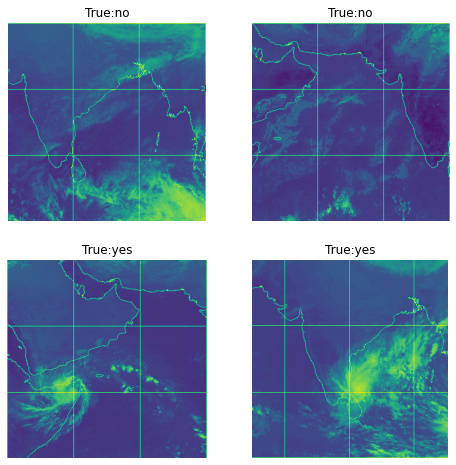

In [10]:
show_few_images(2)

Training images

NO: 566
YES: 726
Total Training images: 1292
*************************************************


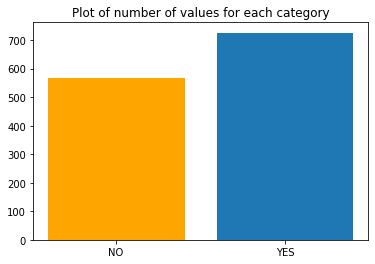


Validation images

NO: 142
YES: 182
Total Validation images: 324
*************************************************


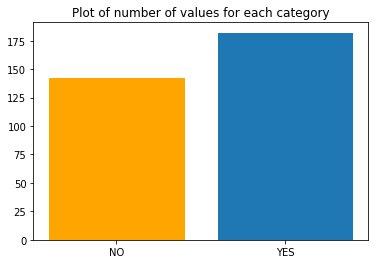

In [11]:
print('Training images\n')
print('NO:', len(os.listdir(train+'/no')))
print('YES:', len(os.listdir(train+'/yes')))
print('Total Training images:', len(os.listdir(train+'/no')) + len(os.listdir(train+'/yes')))
print('*'*49)
bar_plot(train)
print('\nValidation images\n')
print('NO:', len(os.listdir(val+'/no')))
print('YES:', len(os.listdir(val+'/yes')))
print('Total Validation images:', len(os.listdir(val+'/no')) + len(os.listdir(val+'/yes')))
print('*'*49)
bar_plot(val)

# **Data Preparation**

In [12]:
# hyperparameters config
width, height = 310, 310
train_batch_size = 2
val_batch_size = 1

Data generator for train set included augmentation and processing (shear, zoom, horizontal_flip, rescale). For the test set only rescale should be made (we don't want to mess with new data - just predict its class).

In [13]:
trainDataGen = ImageDataGenerator(rescale = 1./255, rotation_range = 10, width_shift_range = 0.1)
validationDataGen = ImageDataGenerator(rescale = 1./255.)

It is important to put "shuffle" equal to False in test generator. Otherwise order of test pictures will be distorted by the function and predictions won't fit order expected by Kaggle checking system.

For test data batch size is 1 as we apply trained model to all test pictures without separating them by batches.

In [14]:
train_generator = trainDataGen.flow_from_directory(train, target_size = (height, width), batch_size = train_batch_size, class_mode = 'binary', shuffle = True)
validation_generator = validationDataGen.flow_from_directory(val, target_size = (height, width), batch_size = val_batch_size, class_mode = 'binary', shuffle = False)

Found 1292 images belonging to 2 classes.
Found 324 images belonging to 2 classes.


# **VGG-16**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
vgg16_model = VGG16(pooling = 'avg', weights = 'imagenet', include_top = False, input_shape = (height, width, 3))

for layers in vgg16_model.layers:
    layers.trainable = False

last_output = vgg16_model.layers[-1].output

vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(1, activation = 'sigmoid')(vgg_x)

vgg16_final_model = Model(vgg16_model.input, vgg_x)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_final_model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [f1, 'acc'])

In [ ]:
validation_steps = validation_generator.samples // val_batch_size
training_steps   = train_generator.samples // train_batch_size

In [ ]:
history = vgg16_final_model.fit(train_generator, steps_per_epoch = training_steps, epochs = 15, validation_data = validation_generator,
                                validation_steps = validation_steps)

Epoch 1/15
646/646 [==============================] - 43s 65ms/step - loss: 0.3881 - f1: 0.6574 - acc: 0.8173 - val_loss: 0.3212 - val_f1: 0.4321 - val_acc: 0.8488
Epoch 2/15
646/646 [==============================] - 41s 63ms/step - loss: 0.2712 - f1: 0.7167 - acc: 0.8831 - val_loss: 0.5044 - val_f1: 0.3210 - val_acc: 0.7593
Epoch 3/15
646/646 [==============================] - 41s 63ms/step - loss: 0.2313 - f1: 0.7301 - acc: 0.8994 - val_loss: 0.5216 - val_f1: 0.3148 - val_acc: 0.7531
Epoch 4/15
646/646 [==============================] - 46s 70ms/step - loss: 0.1867 - f1: 0.7487 - acc: 0.9249 - val_loss: 0.6962 - val_f1: 0.2747 - val_acc: 0.7130
Epoch 5/15
646/646 [==============================] - 43s 66ms/step - loss: 0.1604 - f1: 0.7461 - acc: 0.9342 - val_loss: 0.5062 - val_f1: 0.3519 - val_acc: 0.7901
Epoch 6/15
646/646 [==============================] - 41s 64ms/step - loss: 0.1556 - f1: 0.7466 - acc: 0.9303 - val_loss: 0.1056 - val_f1: 0.5401 - val_acc: 0.9630
Epoch 7/15
646/6

In [ ]:
vgg16_final_model.save("/content/drive/MyDrive/binary_vgg16_model.hdf5")

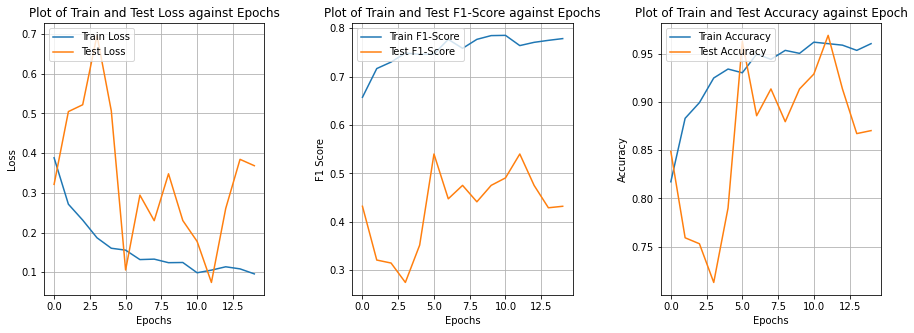

In [ ]:
plot_performance_metrics(history)

In [ ]:
validation_generator.reset()
prediction = model1.predict(validation_generator, steps = validation_steps, verbose = 1)
actual_class = validation_generator.classes

324/324 [==============================] - 2s 6ms/step


True Positive  (TP) =  141
False Positive (FP) =  1
False Negative (FN) =  9
True Negative  (TN) =  173
--------------------------
Precision Score: 99.3%
Recall Score: 94.0%
F1 Score: 96.58%




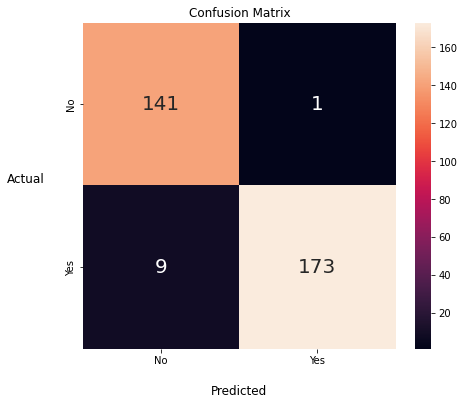

In [ ]:
plot_confusion_matrix(prediction, actual_class)

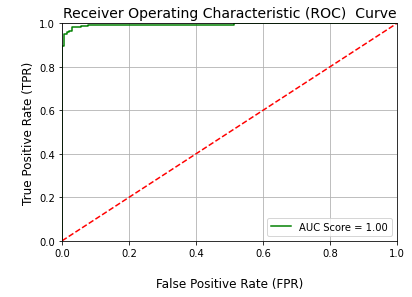


 Classification Report: 

               precision    recall  f1-score   support

          No       0.94      0.99      0.97       142
         Yes       0.99      0.95      0.97       182

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       0.97      0.97      0.97       324



In [ ]:
plot_roc_curve(prediction, actual_class)
print('='*55)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["No", "Yes"]))
print('='*55)

# **ResNet-50**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
ResNet50_model = ResNet50(weights = 'imagenet', include_top = False, input_shape = (310, 310, 3), classes = 2)
for layers in ResNet50_model.layers:
    layers.trainable = True

# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256, activation='relu')(resnet50_x)
resnet50_x = Dense(1, activation = 'sigmoid')(resnet50_x)
resnet50_x_final_model = Model(inputs = ResNet50_model.input, outputs = resnet50_x)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
resnet50_x_final_model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [f1, 'acc'])

In [ ]:
validation_steps = validation_generator.samples // 1
training_steps   = train_generator.samples // 2

In [ ]:
history = resnet50_x_final_model.fit(train_generator, steps_per_epoch = training_steps, epochs = 15, verbose = 1, validation_data = validation_generator, validation_steps = validation_steps)

Epoch 1/15
646/646 [==============================] - 85s 112ms/step - loss: 3.4604 - f1: 0.6605 - acc: 0.8197 - val_loss: 3.8859 - val_f1: 0.4691 - val_acc: 0.8488
Epoch 2/15
646/646 [==============================] - 71s 109ms/step - loss: 0.9774 - f1: 0.7312 - acc: 0.8909 - val_loss: 3.7799 - val_f1: 0.0401 - val_acc: 0.4691
Epoch 3/15
646/646 [==============================] - 69s 106ms/step - loss: 0.5044 - f1: 0.7415 - acc: 0.9087 - val_loss: 1.0447 - val_f1: 0.4537 - val_acc: 0.8858
Epoch 4/15
646/646 [==============================] - 67s 104ms/step - loss: 0.5991 - f1: 0.7528 - acc: 0.9334 - val_loss: 0.1691 - val_f1: 0.4969 - val_acc: 0.9290
Epoch 5/15
646/646 [==============================] - 68s 104ms/step - loss: 0.3258 - f1: 0.7709 - acc: 0.9489 - val_loss: 1.3101 - val_f1: 0.5494 - val_acc: 0.9228
Epoch 6/15
646/646 [==============================] - 67s 104ms/step - loss: 0.2795 - f1: 0.7740 - acc: 0.9512 - val_loss: 0.2837 - val_f1: 0.5617 - val_acc: 0.9475
Epoch 7/15

In [ ]:
resnet50_x_final_model.save("/content/drive/MyDrive/binary_resnet_model.hdf5")

In [ ]:
plot_performance_metrics(history)

In [ ]:
validation_generator.reset()
prediction = resnet50_x_final_model.predict(validation_generator, steps = validation_steps, verbose = 1)
actual_class = validation_generator.classes

In [ ]:
plot_confusion_matrix(prediction, actual_class)

In [ ]:
plot_roc_curve(prediction, actual_class)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["No", "Yes"]))

# **InceptionV3**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
InceptionV3_model = InceptionV3(input_shape = (310, 310, 3), weights = 'imagenet', include_top = False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True

InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation = 'relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(1, activation = 'sigmoid')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs = InceptionV3_model.input, outputs = InceptionV3_x)

87924736/87910968 [==============================] - 3s 0us/step


In [ ]:
InceptionV3_x_final_model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
validation_steps = validation_generator.samples // 1
training_steps   = train_generator.samples // 2

In [ ]:
history = InceptionV3_x_final_model.fit(train_generator, steps_per_epoch = training_steps, epochs = 15, verbose = 1,
                                   validation_data = validation_generator, validation_steps = validation_steps)

Epoch 1/15
646/646 [==============================] - 68s 106ms/step - loss: 0.4048 - f1: 0.7792 - acc: 0.9729 - val_loss: 0.3768 - val_f1: 0.5556 - val_acc: 0.9691
Epoch 2/15
646/646 [==============================] - 64s 99ms/step - loss: 0.2956 - f1: 0.7864 - acc: 0.9837 - val_loss: 0.4791 - val_f1: 0.5586 - val_acc: 0.9722
Epoch 3/15
646/646 [==============================] - 62s 96ms/step - loss: 0.3951 - f1: 0.7931 - acc: 0.9791 - val_loss: 0.2826 - val_f1: 0.5586 - val_acc: 0.9846
Epoch 4/15
646/646 [==============================] - 63s 97ms/step - loss: 0.1251 - f1: 0.8019 - acc: 0.9915 - val_loss: 0.1406 - val_f1: 0.5586 - val_acc: 0.9938
Epoch 5/15
646/646 [==============================] - 61s 95ms/step - loss: 0.0689 - f1: 0.8308 - acc: 0.9969 - val_loss: 0.3282 - val_f1: 0.5556 - val_acc: 0.9907
Epoch 6/15
646/646 [==============================] - 61s 94ms/step - loss: 0.1282 - f1: 0.8003 - acc: 0.9930 - val_loss: 0.5259 - val_f1: 0.5586 - val_acc: 0.9907
Epoch 7/15
646/

In [ ]:
InceptionV3_x_final_model.save("/content/drive/MyDrive/binary_inception_model.hdf5")

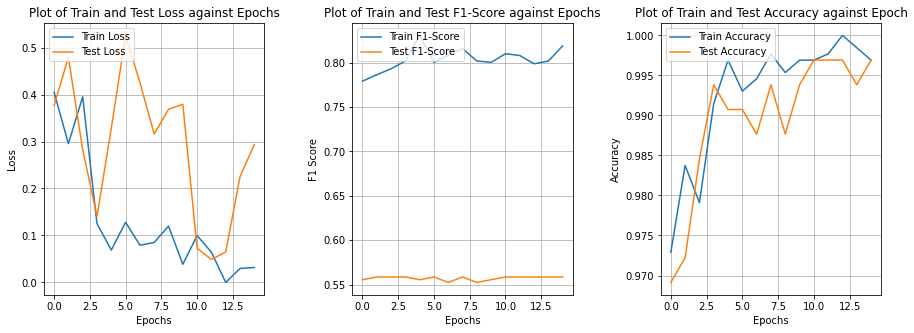

In [ ]:
plot_performance_metrics(history)

In [ ]:
validation_generator.reset()
prediction = InceptionV3_x_final_model.predict(validation_generator, steps = validation_steps, verbose = 1)
actual_class = validation_generator.classes

324/324 [==============================] - 9s 24ms/step


True Positive  (TP) =  142
False Positive (FP) =  0
False Negative (FN) =  1
True Negative  (TN) =  181
--------------------------
Precision Score: 100.0%
Recall Score: 99.3%
F1 Score: 99.65%




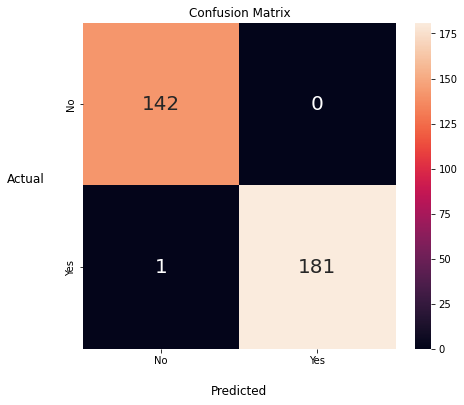

In [ ]:
plot_confusion_matrix(prediction, actual_class)

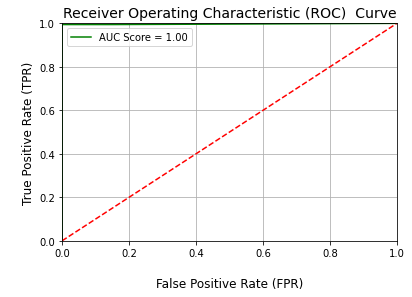


 Classification Report: 

               precision    recall  f1-score   support

          No       0.99      1.00      1.00       142
         Yes       1.00      0.99      1.00       182

    accuracy                           1.00       324
   macro avg       1.00      1.00      1.00       324
weighted avg       1.00      1.00      1.00       324



In [ ]:
plot_roc_curve(prediction, actual_class)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["No", "Yes"]))

# **XceptionNet**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications.xception import Xception
xception_model = Xception(include_top = False, weights = "imagenet", input_shape = (310, 310, 3))
x = Flatten()(xception_model.output)
x = Dropout(0.5)(x)
x = Dense(512, activation=relu)(x)
x = Dropout(0.5)(x)
x = Dense(512, activation=relu)(x)
x = Dense(1, activation=sigmoid)(x)

xception_final_model = Model(inputs = xception_model.input, outputs = x)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
xception_final_model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
validation_steps = validation_generator.samples // 1
training_steps   = train_generator.samples // 2

In [ ]:
history = xception_final_model.fit(train_generator, steps_per_epoch = training_steps, epochs = 15, verbose = 1,
                                   validation_data = validation_generator, validation_steps = validation_steps)

In [ ]:
xception_final_model.save("/content/drive/MyDrive/binary_xception_model.hdf5")

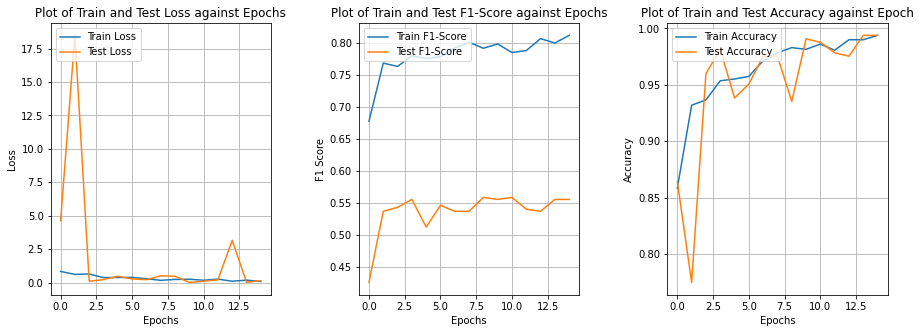

In [ ]:
plot_performance_metrics(history)

In [ ]:
validation_generator.reset()
prediction = xception_final_model.predict(validation_generator, steps = validation_steps, verbose = 1)
actual_class = validation_generator.classes

324/324 [==============================] - 2s 6ms/step


True Positive  (TP) =  141
False Positive (FP) =  1
False Negative (FN) =  9
True Negative  (TN) =  173
--------------------------
Precision Score: 99.3%
Recall Score: 94.0%
F1 Score: 96.58%




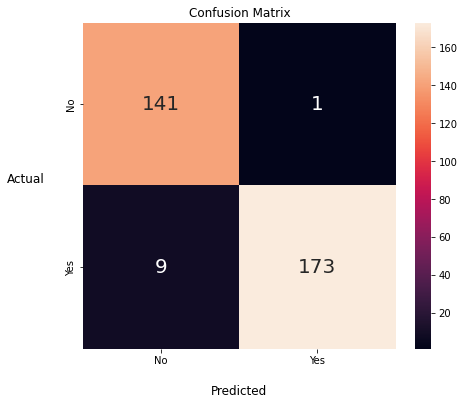

In [ ]:
plot_confusion_matrix(prediction, actual_class)

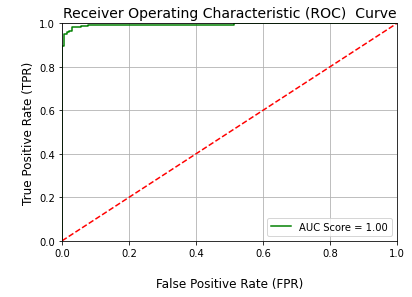


 Classification Report: 

               precision    recall  f1-score   support

          No       0.94      0.99      0.97       142
         Yes       0.99      0.95      0.97       182

    accuracy                           0.97       324
   macro avg       0.97      0.97      0.97       324
weighted avg       0.97      0.97      0.97       324



In [ ]:
plot_roc_curve(prediction, actual_class)
print('='*55)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["No", "Yes"]))
print('='*55)

# **AlexNet**

In [15]:
tf.keras.backend.clear_session()

In [16]:
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [17]:
num_classes = 2
model = AlexNet((310, 310, 3), num_classes)

In [ ]:
history = model.fit(train_generator, epochs=15, validation_data=validation_generator, verbose=1)

Epoch 1/15
646/646 [==============================] - 732s 1s/step - loss: 69.1766 - acc: 0.5619 - val_loss: 0.5766 - val_acc: 0.5617
Epoch 2/15
646/646 [==============================] - 39s 60ms/step - loss: 0.9847 - acc: 0.5619 - val_loss: 3.2551 - val_acc: 0.5617
Epoch 3/15
646/646 [==============================] - 39s 60ms/step - loss: 0.9838 - acc: 0.5619 - val_loss: 0.1282 - val_acc: 0.5617
Epoch 4/15
646/646 [==============================] - 39s 60ms/step - loss: 1.0443 - acc: 0.5619 - val_loss: 10.2931 - val_acc: 0.5617
Epoch 5/15
646/646 [==============================] - 39s 60ms/step - loss: 0.8814 - acc: 0.5619 - val_loss: 0.3521 - val_acc: 0.5617
Epoch 6/15
646/646 [==============================] - 39s 60ms/step - loss: 0.8376 - acc: 0.5619 - val_loss: 0.1545 - val_acc: 0.5617
Epoch 7/15
646/646 [==============================] - 40s 62ms/step - loss: 0.5889 - acc: 0.5619 - val_loss: 0.3569 - val_acc: 0.5617
Epoch 8/15
646/646 [==============================] - 39s 61m

In [ ]:
model.save('/content/drive/MyDrive/binary_alexnet_model.hdf5')

In [ ]:
plot_performance_metrics(history)

In [ ]:
validation_generator.reset()
prediction = model.predict(validation_generator, steps = validation_steps, verbose = 1)
actual_class = validation_generator.classes

In [ ]:
plot_confusion_matrix(prediction, actual_class)

In [ ]:
plot_roc_curve(prediction, actual_class)
print('='*55)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["No", "Yes"]))
print('='*55)

# **Proposed Model**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (width, height, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dropout(0.3))

model.add(Dense(units = 512, activation = 'relu'))

model.add(Dropout(0.3))

model.add(Dense(1, activation = 'sigmoid'))

In [ ]:
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc']) 

In [ ]:
validation_steps = validation_generator.samples // val_batch_size  
training_steps   = train_generator.samples // train_batch_size  

In [ ]:
'''
save_at = "/content/drive/MyDrive/binary_proposed_model.hdf5"
save_best = ModelCheckpoint (save_at, monitor = 'val_acc', verbose = 0, save_best_only = True, save_weights_only = False, mode = 'max')
'''

'\nsave_at = "/content/drive/MyDrive/binary_proposed_model.hdf5"\nsave_best = ModelCheckpoint (save_at, monitor = \'val_acc\', verbose = 0, save_best_only = True, save_weights_only = False, mode = \'max\')\n'

In [ ]:
proposed_model = model.fit(train_generator, steps_per_epoch = training_steps, epochs = 15, validation_data = validation_generator, validation_steps = validation_steps)

Epoch 1/15
646/646 [==============================] - 35s 52ms/step - loss: 0.4345 - acc: 0.8754 - val_loss: 0.5289 - val_acc: 0.8920
Epoch 2/15
646/646 [==============================] - 34s 52ms/step - loss: 0.2396 - acc: 0.9365 - val_loss: 0.2411 - val_acc: 0.9383
Epoch 3/15
646/646 [==============================] - 40s 61ms/step - loss: 0.2241 - acc: 0.9450 - val_loss: 0.0703 - val_acc: 0.9722
Epoch 4/15
646/646 [==============================] - 35s 55ms/step - loss: 0.2942 - acc: 0.9559 - val_loss: 0.2005 - val_acc: 0.9444
Epoch 5/15
646/646 [==============================] - 34s 52ms/step - loss: 0.2076 - acc: 0.9551 - val_loss: 0.3610 - val_acc: 0.9167
Epoch 6/15
646/646 [==============================] - 35s 54ms/step - loss: 0.2321 - acc: 0.9512 - val_loss: 0.1276 - val_acc: 0.9599
Epoch 7/15
646/646 [==============================] - 33s 52ms/step - loss: 0.2269 - acc: 0.9458 - val_loss: 0.5577 - val_acc: 0.9228
Epoch 8/15
646/646 [==============================] - 33s 51ms

In [ ]:
model.save("/content/drive/MyDrive/binary_proposed_model.hdf5")

In [ ]:
proposed_binary_model = load_model('/content/drive/MyDrive/binary_proposed_model.hdf5')

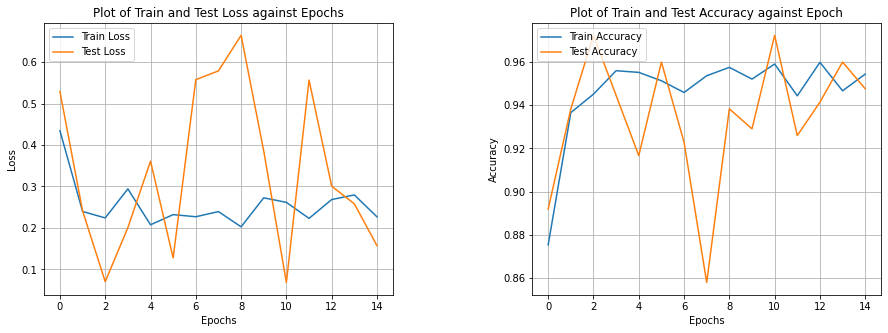

In [ ]:
plot_performance_metrics(proposed_model)

In [ ]:
validation_generator.reset()
prediction = model.predict(validation_generator, steps = validation_steps, verbose = 1)
actual_class = validation_generator.classes

324/324 [==============================] - 2s 6ms/step


True Positive  (TP) =  129
False Positive (FP) =  13
False Negative (FN) =  4
True Negative  (TN) =  178
--------------------------
Precision Score: 90.85%
Recall Score: 96.99%
F1 Score: 93.82%




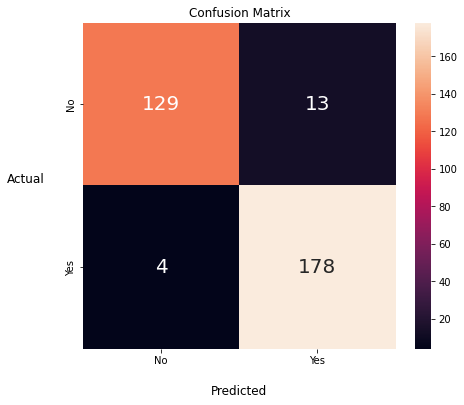

In [ ]:
plot_confusion_matrix(prediction, actual_class)

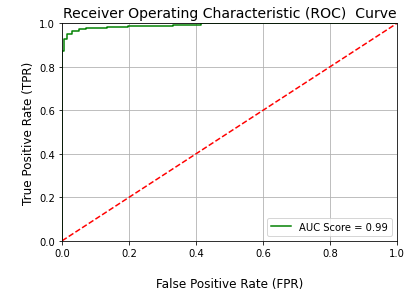


 Classification Report: 

               precision    recall  f1-score   support

          No       0.97      0.91      0.94       142
         Yes       0.93      0.98      0.95       182

    accuracy                           0.95       324
   macro avg       0.95      0.94      0.95       324
weighted avg       0.95      0.95      0.95       324



In [ ]:
plot_roc_curve(prediction, actual_class)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(prediction), target_names = ["No", "Yes"]))

# **Testing**

In [ ]:
test = '/content/drive/MyDrive/cyclone_testing/binary_test'

In [ ]:
testDataGen = ImageDataGenerator(rescale = 1./255.)

In [ ]:
test_generator = testDataGen.flow_from_directory(test, target_size = (height, width), class_mode = 'binary', batch_size = 1, shuffle = False)

Found 37 images belonging to 2 classes.


In [ ]:
predictions = proposed_binary_model.predict(test_generator)
actual_class = test_generator.classes

37/37 [==============================] - 21s 568ms/step


True Positive  (TP) =  16
False Positive (FP) =  0
False Negative (FN) =  0
True Negative  (TN) =  21
--------------------------
Precision Score: 100.0%
Recall Score: 100.0%
F1 Score: 100.0%




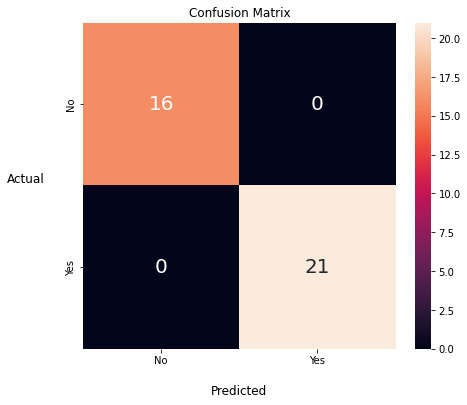

In [ ]:
plot_confusion_matrix(predictions, actual_class)

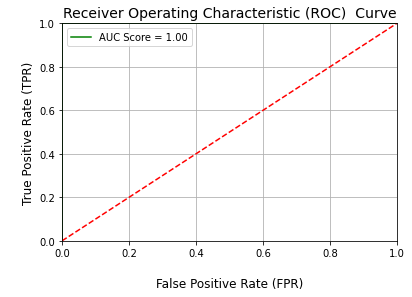


 Classification Report: 

               precision    recall  f1-score   support

          No       1.00      1.00      1.00        16
         Yes       1.00      1.00      1.00        21

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [ ]:
plot_roc_curve(predictions, actual_class)
print("\n Classification Report: \n\n", classification_report(actual_class, predict_classes(predictions), target_names = ["No", "Yes"]))

In [ ]:
test_loss, test_accuracy = proposed_binary_model.evaluate(test_generator, batch_size = 1)
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

37/37 [==============================] - 0s 9ms/step - loss: 0.0231 - acc: 1.0000
Test Loss:     0.0230985376983881
Test Accuracy: 1.0


# **Visualization**

In [ ]:
for layer in model.layers:
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d (3, 3, 3, 32)
conv2d_1 (3, 3, 32, 64)
conv2d_2 (3, 3, 64, 128)
conv2d_3 (3, 3, 128, 128)


In [ ]:
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)